In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [7]:
assessments=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/first_project_var_2/assessments (1).csv')
courses=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/first_project_var_2/courses.csv')
student_as=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/first_project_var_2/studentAssessment (1).csv')
student_reg=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashchenko/first_project_var_2/studentRegistration.csv')

### assessments.csv — этот файл содержит информацию об оценках в тесте.     
Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
code_module — идентификационный код предмета.      
code_presentation — семестр (Идентификационный код).        
id_assessment — тест (Идентификационный номер ассессмента).            
assessment_type — тип теста. 
Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).      
date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

### courses.csv — файл содержит список предметов по семестрам.         
code_module — предмет (идентификационный код).          
code_presentation — семестр (идентификационный код).        
module_presentation_length — продолжительность семестра в днях.

### studentAssessment.csv — этот файл содержит результаты тестов студентов. 
Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

id_assessment — тест (идентификационный номер).       
id_student — идентификационный номер студента.       
date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.    
is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).           
score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.


### studentRegistration.csv — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.     
code_module — предмет (идентификационный код).         
code_presentation — семестр (идентификационный код)        
id_student — идентификационный номер студента.           
date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).         
date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

### 1. Сколько студентов успешно сдали только один курс?
Успешная сдача — это зачёт по курсу на экзамене.Для решения задачи нам необходимы 2 датафрейма:
assessments - с информацией об экзаменах.student_as - файл с оценками студентов.
 Начнем с того, что посмотрим на информацию в нужных датафреймах:

In [8]:
student_as.head(5)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [9]:
# Проверим пропуски
student_as.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

 В колонке 'score' есть 173 пропущенных значения, но, так как для успешной сдачи нам нужно значение >= 40, это никак не повлияет

In [10]:
 # Посмотрим на перезачеты:
student_as.is_banked.value_counts()

0    172003
1      1909
Name: is_banked, dtype: int64

 Кол-во перезачетов составило 1909, будем иметь это в виду, при обработке данных

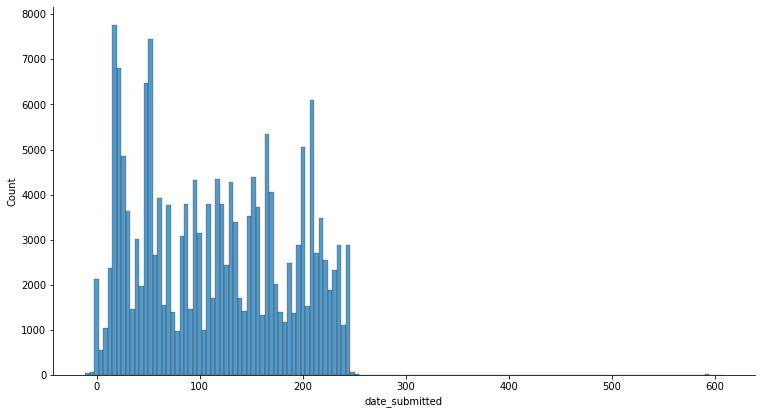

In [11]:
# Посмотрим на распределение даты зачета
sns.displot(student_as, x='date_submitted', palette="light")
plt.gcf().set_size_inches(12, 6)

 У нас есть странные отрицательные значения, давайте посмотрим на них

In [12]:
 # Посмотрим на значения с date_submitted < 0
student_as[student_as.date_submitted < 0].head(5)

,id_assessment,id_student,date_submitted,is_banked,score
1641,1758,603861,-1,1,61.0
1685,1758,1970390,-1,1,78.0
1690,1758,2073016,-1,1,60.0
1693,1758,2139353,-1,1,65.0
1708,1758,2358969,-1,1,68.0


 Судя по всему, перезачетам проставляется дата -1, давайте это проверим

In [13]:
 # Сгрупперуем данные с отрицательными значениями
student_as[student_as.date_submitted < 0].date_submitted.value_counts()

-1     1927
-8       37
-3       30
-2       25
-5       13
-4       12
-6        6
-7        4
-11       1
-9        1
-10       1
Name: date_submitted, dtype: int64

 Да, действительно все наши 1909 перезачетов имеют дату -1.
Помимо этого, у нас есть и другие значения с датой < 0. Но так как они не являются пересдачей, скорее всего, была проставлена ошибочная дата.

In [14]:
 # Посмотрим на датафрейм 'assessments'
assessments.head(5) 

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [15]:
# Проверим на пропуски
assessments.isnull().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

 Пропуски только в датах, возможно точных дат сдачи не было, или их забыли проставить.      
 Приступим к решению задачи.

In [16]:
 #  В датафрейме `assessments` оставим только данные по экзаменам и сохраняем в переменную `as_exam`
as_exam = assessments[assessments.assessment_type == 'Exam']

In [17]:
# Объеденим 2 датафрейма в новый `students_exam` по колонке id_assessment
students_exam = student_as.merge(as_exam,on='id_assessment')

In [18]:
# Посмотрим, как выглядит полученный датафрейм
students_exam.head(5)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


 Чтобы избежать случаев, когда один студент завершил один и тот же курс 2 раза, будем использовать количество уникальных курсов для каждого студента.

In [19]:
# Оставляем значения score >= 40 & is_banked == 0, группируем по id_student, находим количество уникальных значения code_module, переименовав колонку в finished_module

suc_stud_exam = students_exam \
    .query('score >= 40 & is_banked == 0') \
    .groupby(['id_student'], as_index=False) \
    .code_module.nunique() \
    .rename(columns={'code_module': 'finished_module'}) \
    .sort_values('finished_module')

In [20]:
 # Найдем какое количество курсов закончило какое количество студентов
suc_stud_exam.finished_module.value_counts()

1    3805
2     292
Name: finished_module, dtype: int64

## Вывод:
Количество студентов сдавших только 1 курс: 3805Количество студентов сдавших 2 курса: 292Студенты не заканчивали более 2х курсов.

### 2. Выявить самый сложный и самый простой экзамен: найти курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью
Определим, что завершаемость -  это отношение количества студентов успешно сдавших экзамен по курсу к общему числу студентов на этом курсе.Так как нам вновь нужны данные связанные с экзаменами, будем использовать датафрейм 'students_exam' из предыдущего задания

In [22]:
# Для каждого модуля и экзамена найдем кол-во студентов успешно сдавших его.
id_assessment_success = students_exam \
    .loc[students_exam.score >= 40] \
    .groupby(['code_module','id_assessment'],as_index=False) \
    .id_student.count() \
    .rename(columns={'id_student' : 'success'})

In [23]:
# Для каждого модуля и экзамена найдем общее кол-во студентов .
id_assessment_total = students_exam \
    .groupby('id_assessment',as_index=False) \
    .id_student.count() \
    .rename(columns={'id_student' : 'total'})

In [24]:
# Объеденим два полученных датафрейма
id_assessment_ratio = id_assessment_success.merge(id_assessment_total,on='id_assessment')

# Добавим столбец 'ratio' - завершаемость экзамена из условия
id_assessment_ratio['ratio'] = round(id_assessment_ratio.success / id_assessment_ratio.total,2)
id_assessment_ratio = id_assessment_ratio.sort_values('ratio', ascending=False)

In [25]:
# Посмотрим на получившийся датафрейм
id_assessment_ratio

,code_module,id_assessment,success,total,ratio
4,DDD,25361,485,524,0.93
3,DDD,25354,878,968,0.91
0,CCC,24290,664,747,0.89
5,DDD,25368,842,950,0.89
1,CCC,24299,1019,1168,0.87
2,DDD,25340,504,602,0.84


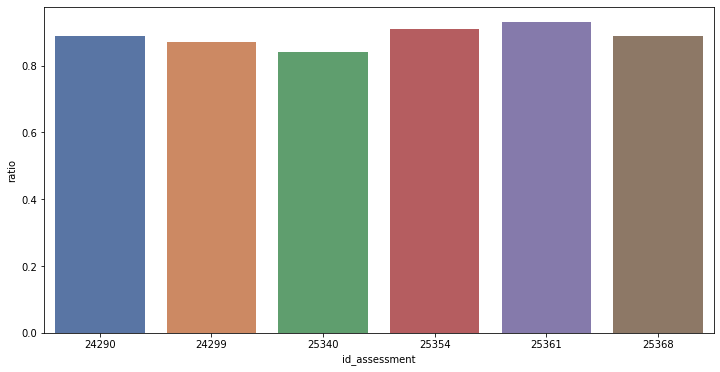

In [26]:
 # Визуализируем данные
f, ax1 = plt.subplots(1, figsize=(12, 6), sharex=True)
sns.barplot(data = id_assessment_ratio, x='id_assessment', y='ratio', palette="deep")

## Вывод:
 Самый сложный экзамен - 25340 из модуля DDD c % успеха = 84.0; Самый простой экзамен - 25361 из модуля DDD c % успеха = 93.0;В целом, все экзамены находятся примерно на одном уровне, и имеют достаточно высокую завершаемость.

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).
Будем считать получение оценки 40 и выше - последнее успешное прохождение экзамена студентом.Дополнительно узнаем -  успевают ли в среднем студенты в срок сдачи ?Нам вновь нужны данные связанные с экзаменами, будем использовать датафрейм 'students_exam' из предыдущих заданий

In [28]:
# Найдем данные по успешно пройденным экзаменам и запишем их в переменную 's_stud_exam'
s_stud_exam = students_exam.query('score >= 40 & is_banked == 0')

In [29]:
# Найдем средний срок сдачи экзаменов и окончательную дату по тестам
s_stud_exam \
    .loc[:,['code_module', 'date_submitted', 'date']] \
    .groupby('code_module', as_index=False) \
    .mean() \
    .round()

,code_module,date_submitted,date
0,CCC,239.0,NaN
1,DDD,238.0,250.0


 У нас есть полностью отсутсвующие данные по модулю ССС в столбце date. Возможно они есть и у модуля DDD, давайте проверим

In [30]:
 # Посчитаем количество пропущенных значений
s_stud_exam[s_stud_exam['code_module'] == "DDD"].date.isnull().sum()

842

 У предмета 'DDD' также есть пропуски. Давайте попробуем восстановить данные.Судя по описанию, возможно, нам подходит колонка 'module_presentation_length' из  файла 'courses.csv'

In [31]:
 # Посмотрим на этот файл
courses.head(10)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


In [32]:
# Объеденим наш датафрейм с 'courses' и запишем его в новую переменную 'm_stud_exam'
m_stud_exam = s_stud_exam.merge(courses, on=['code_module', 'code_presentation'])

In [33]:
# отфильтруем данные по предметам, уберем пустые значения  и запишем результат в переменную 'filtred_m_stud_exam'
filtred_m_stud_exam =  m_stud_exam[(m_stud_exam.code_module == 'DDD') & (m_stud_exam.date.notnull())]

 Теперь сравним 2 колонки между собой, что бы посмотреть есть ли расхождения в данных, по которым не было пропусков:

In [34]:
filtred_m_stud_exam[filtred_m_stud_exam['date'] != filtred_m_stud_exam['module_presentation_length']]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length


 Расхождений нет, потому можем использовать эту колонку как финальную дату сдачи по экзамену.

In [36]:
# Найдем средний срок сдачи экзаменов и окончательную дату по тестам
final_stud_exam = m_stud_exam \
    .loc[:,['code_module', 'date_submitted', 'module_presentation_length']] \
    .groupby('code_module', as_index=False) \
    .mean() \
    .round()
final_stud_exam

,code_module,date_submitted,module_presentation_length
0,CCC,239.0,258.0
1,DDD,238.0,254.0


## Вывод:
По предмету CCC средний срок сдачи итогового экзамена 239 днейПо предмету DDD средний срок сдачи итогового экзамена 238 днейВ среднем, студенты успевают сдать экзамены в срок.

### 4. Выявить самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).
Для решения нам потребуются данные из датафрейма  - student_regОттоком будем считать -  отношение отменивших регистрацию к числу зарегестрировавщихся  

In [37]:
#Проверим данные на пропуски
student_reg.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

 У нас есть пропуски в датах, но при этом нет пропусков по другим колонкам, значит убирать их из данных мы не будем, а считать кол-во регистраций мы будем по количеству уникальных 'id_students'

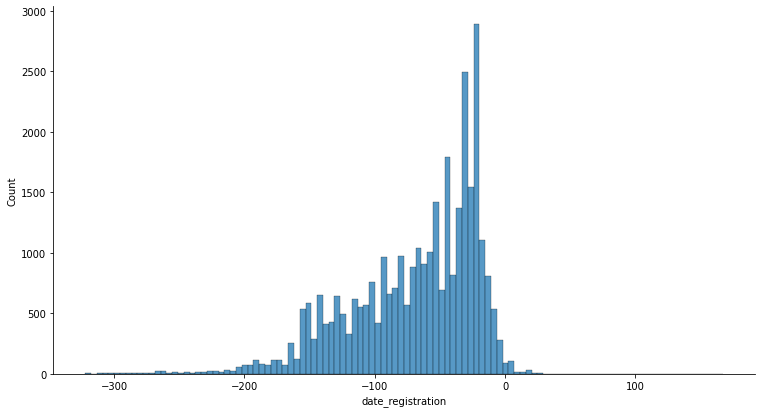

In [38]:
 # Посмотрим как распределились даты регистраций:
sns.displot(student_reg, x='date_registration', palette="light")
plt.gcf().set_size_inches(12, 6)

 В целом, за исключением небольшого количества регистраций сильно заранее, все выглядит логичным

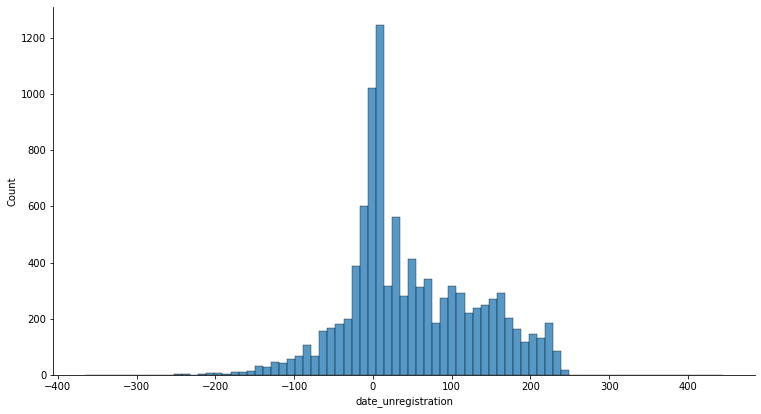

In [39]:
# Посмотрим как распределились даты отмены регистраций:
sns.displot(student_reg, x='date_unregistration', palette="light")
plt.gcf().set_size_inches(12, 6)

 Здесь так же все выглядит логичным Приступим к решению задачи

In [40]:
# Отфильтруем данные и запишем их в переменную 'top_courses'
top_courses = student_reg \
    .groupby('code_module', as_index=False) \
    .agg({'id_student': 'nunique','date_unregistration' : 'count'}) \
    .rename(columns={'id_student' : 'registred', 'date_unregistration' : 'unregistred'}) \
    .sort_values('registred', ascending=False)
# Добавим колонку рейтинга оттока
top_courses['churn_ratio_%'] = top_courses.unregistred.divide(top_courses.registred).mul(100).round(2)

In [41]:
# Посмотрим на получившийся датафрейм

top_courses

,code_module,registred,unregistred,churn_ratio_%
1,BBB,7692,2377,30.90
5,FFF,7397,2380,32.18
3,DDD,5848,2235,38.22
2,CCC,4251,1947,45.80
4,EEE,2859,718,25.11
6,GGG,2525,289,11.45
0,AAA,712,126,17.70


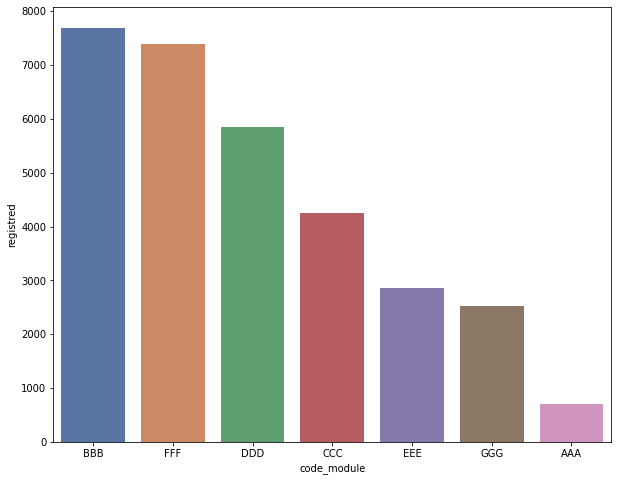

In [42]:
# Выведем курсы по количеству регистраций
top_courses_reg =  top_courses.sort_values('registred', ascending=False)
f, ax1 = plt.subplots(1, figsize=(10, 8), sharex=True)
sns.barplot(data = top_courses_reg, x='code_module', y='registred', palette="deep")

In [43]:
# Отбабразим топ-3 курсов по количеству регистраций:
top_courses_reg.head(3)

,code_module,registred,unregistred,churn_ratio_%
1,BBB,7692,2377,30.90
5,FFF,7397,2380,32.18
3,DDD,5848,2235,38.22


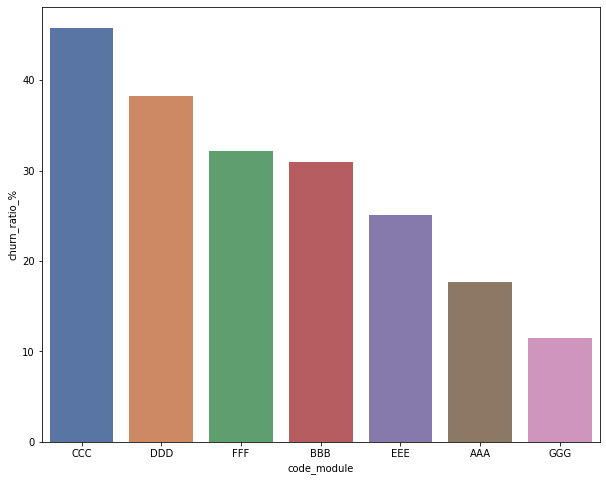

In [44]:
# Выведем курсы по % оттока
top_courses_churn = top_courses.sort_values('churn_ratio_%', ascending=False)
f, ax1 = plt.subplots(1, figsize=(10, 8), sharex=True)
sns.barplot(data = top_courses_churn, x='code_module', y='churn_ratio_%', palette="deep")

In [45]:
#Выведем топ-3 курса по рейтингу оттока

top_courses_churn.head(3)

,code_module,registred,unregistred,churn_ratio_%
2,CCC,4251,1947,45.80
3,DDD,5848,2235,38.22
5,FFF,7397,2380,32.18


## Вывод:
Топ-3 курсов по количеству регистраций:
BBB, FFF, DDDТоп-3 курса по рейтингу оттока:
CCC, DDD, FFFНе смотря на то, что курс CCC имеет "среднее" количество регистраций, он обладает очень большим показателем оттока, возможно стоит сосредоточить внимание и проверить, что вызыввает сложности у студентов.

### 5. Написать функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [46]:
def cohort(assessments,student_as):
    

    # Фильтруем данные в датафрейме `assessments` и сохраняем в переменную `as_exam`
    as_exam = assessments[assessments.assessment_type == 'Exam']

    # Объединим as_exam и student_as
    exam_data = student_as.merge(as_exam,on='id_assessment')

    # Сгрупперуем данные по семестру и найдем средний срок сдачи
    cohort_ass = exam_data \
        .groupby('code_presentation',as_index=False) \
        .date_submitted.mean() \
        .rename(columns={'date_submitted': 'mean_date'}) \
        .round()

    # Отфильтруем данные с успешно сданными экзаменами и посчитаем кол-во студентов в каждом семестре
    id_assessment_success_2 = exam_data \
        .loc[exam_data.score >= 40] \
        .groupby(['code_presentation'],as_index=False) \
        .id_student.count() \
        .rename(columns={'id_student' : 'success'})

    # Посчитаем общее количество студентов с разбивкой по сместрам
    id_assessment_total2 = exam_data \
        .groupby('code_presentation',as_index=False) \
        .id_student.count() \
        .rename(columns={'id_student' : 'total'})

    # Добавим колонку с рейтингом завершаемости курсов по семестрам
    cohort_ass['ratio'] = round(id_assessment_success_2.success / id_assessment_total2.total, 2)
    
    return cohort_ass

In [47]:
cohort(assessments,student_as)

,code_presentation,mean_date,ratio
0,2013B,230.0,0.84
1,2013J,240.0,0.91
2,2014B,233.0,0.90
3,2014J,244.0,0.88


## Вывод:
Семестр с самой низкой завершаемостью - 2013B, c рейтингом 0.84Семестр с самыми долгими средними сроками сдачи - 2014J, со сроком 244.0

### 5. Построить адаптированные RFM-кластеры студентов, чтобы качественно оценить аудиторию.
В адаптированной кластеризации будем использовать следующие метрики: R - период сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.R - период сдачи одного экзамена
Так как среднее время сильно зависит от даты экзамена и длинны семестра, а студентам один и тот же экзамен может быть назначен в разные дни, то есть риск разнести таких студентов в разные категории, потому мы будем делить их по периодам, когда они сдали экзамен.Выберем 3 категории студентов:
Студент пытался сдать, но не сдал экзаменСдал после окончания семестраСдал до конца семестра
При этом, нужно понимать, что если студент относится к 1 категории то и в других метриках у него не может быть отличной категории (так как он не может не сдать экзамен, при этом завершить курс или получить оценку 40 и выше).F - завершаемость курсов
За основу возьмем принцип из первого задания. Нам известно, что никто не завершал более 2х курсов. Потому будем считать категории как кол-во завершенных курсов + 1.Выберем 3 категории студентов:
Студент не завершил курсЗавершил один курсЗавершил два курса
M - среднее количество баллов, получаемое на экзамене.
Здесь у нас будет 4 категории :Из условия у нас есть нижняя планка в 40 баллов. Те, кто получил оценку ниже -  с экзаменом не справились, остальных поделим следующим образом:
Получил меньше 40 балловПолучил от 40 до 65 баллов - УдовлетворительноПолучил от 65 до 85 баллов - ХорошоПолучил 85 и больше - Отлично

In [50]:
#Найдем общее количество студентов сдаваших экзамен, что бы проверять себя
total_students  = students_exam \
        .groupby(['id_student'], as_index=False) \
        .id_student.nunique() \
        .sum()
total_students

id_student    4633
dtype: int64

R

In [51]:
# Объеденим 3 датафрейма и отфильтруем только данные по assessment_type == 'Exam'
ex_date = student_as \
    .merge(assessments,on='id_assessment') \
    .merge(courses, on=['code_module', 'code_presentation']) \
    .query("assessment_type == 'Exam'")
# Создадим колонку разницы в датах отправвки и прододжительности курса
ex_date['date_diff'] = ex_date.date_submitted - ex_date.module_presentation_length

In [52]:
# Проставим значение recency = 1  студентам несдавшим экзамен и запишем в переменную rec_1
rec_1 = ex_date[ex_date.score < 40] \
        .groupby('id_student', as_index=False)\
        .date_diff.mean() \
        .rename(columns={'date_diff': 'recency'})
rec_1['recency'] = '1'

In [53]:
# Проставим значение recency = 2  студентам сдавшим после окончания семестра и запишем в переменную rec_2
rec_2 = ex_date[(ex_date.score >= 40) & (ex_date.date_diff > 0)]\
        .groupby('id_student', as_index=False)\
        .date_diff.mean() \
        .rename(columns={"date_diff": "recency"})
rec_2['recency'] = '2'

In [54]:
 # Проставим значение recency = 3  студентам сдавшим до окончания семестра и запишем в переменную rec_3

rec_3 = ex_date[(ex_date.score >= 40) & (ex_date.date_diff < 0)]\
        .groupby('id_student', as_index=False)\
        .date_diff.mean() \
        .rename(columns={"date_diff": "recency"})
rec_3['recency'] = '3'

In [55]:
# Объеденим все в 1 датафрейм удалив дубликаты
recency = pd.concat([rec_3, rec_2, rec_1]).drop_duplicates('id_student')

In [56]:
 # Проверим кол-во студентов
recency.shape

(4633, 2)

F

In [57]:
# Проставим значение frequency == количество завершенных курсов + 1 - студентам успешно сдавшим экзамен
frequency_s = students_exam \
    .query('score >= 40 & is_banked == 0') \
    .groupby(['id_student'], as_index=False) \
    .code_module.count() \
    .rename(columns={'code_module': 'frequency'}) \
    .sort_values('frequency')
frequency_s.frequency += 1

In [58]:
 # Проставим значение frequency == 1 cтудентам несдавшим экзамен
frequency_f = students_exam \
    .query('score < 40 & is_banked == 0') \
    .groupby(['id_student'], as_index=False) \
    .code_module.count() \
    .rename(columns={'code_module': 'frequency'}) \
    .sort_values('frequency')
frequency_f.frequency = 1

In [59]:
 # Объеденим все в 1 датафрейм удалив дубликаты
frequency = pd.concat([frequency_s, frequency_f]).drop_duplicates('id_student')
# Поменяем формат данных на str
frequency.frequency = frequency.frequency.apply(str)

In [60]:
# Проверим кол-во студентов

frequency.shape

(4633, 2)

M

In [61]:
# Проставим значение monetary, используя функцию cut
monetary = students_exam \
    .groupby(['id_student'], as_index=False) \
    .agg({'score': 'mean'})
bins = [0,40,65,85,101]
monetary['monetary'] = pd.cut(monetary.score, bins, labels=[1, 2, 3, 4], right=False).astype(str)

In [62]:
# Посмотрим на получившиеся кластеры
monetary.monetary.value_counts()

2    1751
3    1428
4     911
1     543
Name: monetary, dtype: int64

In [63]:
# Проверим кол-во студентов
monetary.shape

(4633, 3)

R-F-M

In [64]:
# Объеденим все полученное ранее в итоговые датафрейм с необходимыми показателями
RFM = pd.merge(recency,frequency, on="id_student").merge(monetary, on="id_student")

In [65]:
# Создадим колонку с нужным нам параметром
RFM['rfm'] = RFM.recency + RFM.frequency  + RFM.monetary

In [66]:
# Выведем итоговый результат кластеризации:
RFM.rfm.value_counts()

322    1658
323    1310
324     817
111     536
333     115
334      93
332      87
321       7
222       6
223       3
224       1
Name: rfm, dtype: int64

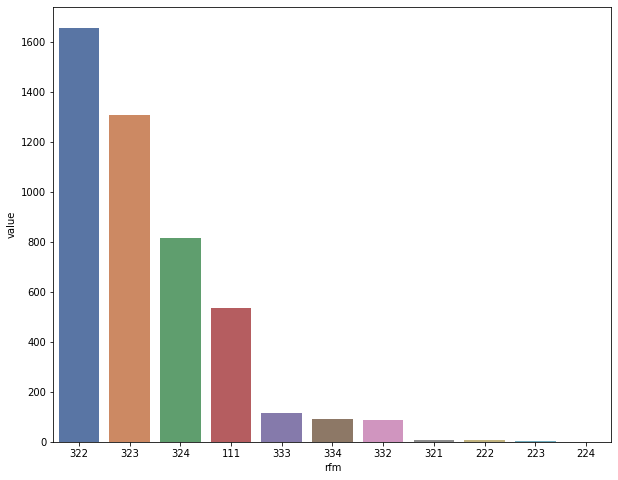

In [67]:
# Визуализируем данные
rfm_f = RFM.groupby('rfm',as_index=False).id_student.nunique().rename(columns={'id_student':'value'}).sort_values('value', ascending=False)
f, ax1 = plt.subplots(1, figsize=(10, 8), sharex=True)
sns.barplot(data = rfm_f,x='rfm', y='value', palette="deep")

Вывод:
Итого у нас вышло 10 кластеров:

322 - завершили один курс вовремя и получили оценку Удовлетворительно323 - завершили один курс вовремя и получили оценку Хорошо324 - завершили один курс вовремя и получили оценку Отлично  111 - не завершили ни одного курса и получили оценку Неудовлетворительно   334 - в среднем уложились в длинну семестра и завершили два курса со средней оценкой Отлично333 - в среднем уложились в длинну семестра и завершили два курса со средней оценкой Хорошо332 - в среднем уложились в длинну семестра и завершили два курса со средней оценкой Удовлетворительно    222 - сдали после окончания семестра, завершили один курс и получили оценку Удовлетворительно223 - сдали после окончания семестра, завершили один курс и получили оценку Хорошо224 - сдали после окончания семестра, завершили один курс и получили оценку Отлично
Так как кластеры с оценкой "Удовлетворительно" превалируют, нужно разобраться в причине такого кол-ва низких оценок. Возможно, стоит обратить внимание на сложность курса и доступность в подаче информации, что бы поправить этот показатель.